In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
cd "/gdrive/MyDrive/Apuntes papers "


[Errno 2] No such file or directory: '/gdrive/MyDrive/Apuntes papers '
/gdrive


In [ ]:
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#networkx para teoría de grafos, matplot para gráficar, random para generar números aleatorios, stats para la entropia y solve para optimizar.
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp 
from scipy import stats as st
import math 
from scipy.optimize import fsolve
import powerlaw

In [ ]:
#Este algoritmo es para muestrar secuencias de enteros on una distribución dada. (Montecarlo
def Degree_Sec_Generator(Probabilidad_Acumulada,longitud_Secuencia,m):
  """
  (Vector Probabilidada Acumulada, Longitud Secuencia,m) -------> (Secuencia de enteros con la distribución del vector)
  Este algoritmo es para muestrar secuencias de enteros on una distribución dada. (Montecarlo)
  recuerde que si quiere una secuencia de grado longitud_Secuencia = len(Probabilidad_Acumulada)
  m corresponde al valor mínimo desde el cual se muestreará la distribución, si no es necesario poner 0.
  """
  Degree_Sequence = []
  sum = 0
  intentos = 100000
  for i in range(intentos):
    k = np.random.rand()*Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]
    #k = st.uniform.rvs(scale = Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]) #Se generan números aleatoriamente entre 0 y 0.9999
    for j in range(len(Probabilidad_Acumulada)): 
      if k <= Probabilidad_Acumulada[j]: # Asocia un entero positivo a cada número entre 0-0.9999
        if j <= round(len(Probabilidad_Acumulada)**(1/2) + 10):
          Degree_Sequence.append(j+m-1) #construye el vector con los enteros positivos asociados a los números entre 0-1
          break
    if len(Degree_Sequence) == longitud_Secuencia:
      break
  return Degree_Sequence
  
def Degre_sec_extractor(G):
  degree_secuence = []
  deg = nx.degree(G)
  for i in range(len(deg)):
    degree_secuence.append(deg(i))
  return degree_secuence

In [ ]:
#esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto
#en el proyecto que sustenta este respositorio
def maxent_generator(cum_probability,number_nodes,m):
  """
  (cum_probability,number_nodes) -----> G
  esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto
  en el proyecto que sustenta este respositorio
  """
  for k in range(1000000000000):
          Degree_Sequence = Degree_Sec_Generator(cum_probability,number_nodes,m) #se genera secuencia
          if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
            if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True: #se comprueba si permite crear un grafo simple conectado
              Degree_Sequence.sort() #ordenamos la secuencia
              Grafo = nx.havel_hakimi_graph(Degree_Sequence) #creamos el grafo con el algoritmo havel hakimi
              break
  nx.double_edge_swap(Grafo,nswap=1000,max_tries=1500000) #Se aleatoriza el grafo manteniendo su secuencia de grado constante
  return Grafo

In [ ]:
#Estas funciones remueven N nodos o enlaces del grafo ingresado
def remove_hubs_load(G,nodos_removidos): #remueve nodos con mayor load
  """
  (G, #nodos_removidos) ---------> G
  """
  for i in range(nodos_removidos):
    keys = list(nx.load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_nodo = values.index(maxval)
    G.remove_node(keys[casilla_nodo])
  return G
 
def edge_remove_hub_load(G,edges_removidos): #remueve edges con mayor load
  """
  (G,#edges_removidos) -------> G
  """
  for i in range(edges_removidos):
    keys = list(nx.edge_load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_edge = values.index(maxval)
    G.remove_edge(keys[casilla_edge][0],keys[casilla_edge][1])
  return G
 
 
def remove_aleatory(G,nodos_removidos): #remueve nodos aleatoriamente
  """
  (G,#nodos_removidos) -----------> G
  """
  keys = list(G.nodes())
  for i in range(nodos_removidos):
    remove_node = np.random.randint(0,G.number_of_nodes())
    remnode = keys[remove_node]
    if (remnode in G) == True:
      G.remove_node(remnode)
  return G
 
def edge_remove_aleatory(G,edges_removidos): #remueve edges aleatoriamente
  """
  (G,#edges_removidos) ------> G
  """
  for i in range(edges_removidos):
    remove_edge = np.random.randint(0,len(nx.edges(G)))
    if (remove_edge in G) ==True:
      G.remove_edge(list(nx.edges(G))[remove_edge][0],list(nx.edges(G))[remove_edge][1])
  return G

In [ ]:
#Estas dos funciones atacan nodos y enlaces en base al ranking en la medida fload y causan una falla en cascada
# la falla en cascada se realiza recalculando el load en la red y eliminando con cierta probabilidad los nodos que tengan un load mayor 
# a su loadinicial*resiliencia, si el load supera un valor dado la probabilidad de eliminación es 100%
 
def hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  Esta función ataca nodos acorde a su ranking en la medida load y luego aplica una falla en cascada
  acorde a que nodos soportan un mayor load que el dado por su capacidad inicial y resiliencia
  """
  load1 = nx.load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  nodes = len(G.nodes())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    NodosBC = len(max(nx.connected_components(G), key=len))
    DAMAGE.append(NodosBC/nodes) #registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
    remove_hubs_load(G,1) #se remueve el nodo con mayor load
    DELETE_NODES = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual un nodo colapsara con 100% de seguridad
      if load[j] > val: 
        DELETE_NODES.append(j) #enlistamos los nodos que colapsaran
      else:
        if load[j] > Capacity[keys1.index(j)]:#se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/Capacity[keys1.index(j)] -1)
          if k <= P:
            DELETE_NODES.append(j) #enlistamos los nodos colapsados
    G.remove_nodes_from(DELETE_NODES) #se eliminan los nodos colapsados
 
  return G,ATTACK,DAMAGE
 
def edge_hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  Esta función ataca nodos acorde a su ranking en la medida load y luego aplica una falla en cascada
  acorde a que nodos soportan un mayor load que el dado por su capacidad inicial y resiliencia
  """
  load1 = nx.edge_load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGEEDGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    NodosBC = len(max(nx.connected_components(G), key = len))
    DAMAGEEDGE.append(NodosBC/len(G.nodes()))#registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
    edge_remove_hub_load(G,1) #se remueve el edge con mas load 
    DELETE_EDGES = []
    load = nx.edge_load_centrality(G)
    for j in G.edges():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual un nodo colapsara con 100% de seguridad
      if load[j] > val:  #enlistamos los nodos que colapsaran
        DELETE_EDGES.append(j)
      else:
        if load[j] > Capacity[keys1.index(j)]: #se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia -1))*(load[j]/Capacity[keys1.index(j)] - 1)
          if k <= P:
            DELETE_EDGES.append(j) #enlistamos los nodos colapsados
    G.remove_edges_from(DELETE_EDGES) #se eliminan los nodos colapsados
    
  return G, ATTACK, DAMAGEEDGE

In [ ]:
def aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el número de ataques)
  Esta función luego de atacar un nodo aleatoriamente ejecuta el algoritmo de falla en cascada y te entrega como resultado
  el grafo atacado, un vector con los daños por ataque y un vector con el número de ataques
  """
  load1 = nx.load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  nodes = len(G.nodes())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    NodosBC = len(max(nx.connected_components(G), key = len))
    DAMAGE.append(NodosBC/len(G.nodes()))#registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
    remove_aleatory(G,1) #se remueve un nodo aleatoriamente
    DELETE_NODES = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual el nodo colapsara con 100% de probabilidad
      if load[j] > val: 
        DELETE_NODES.append(j) #enlistamos los nodos colapsados
      else:
        if load[j] > Capacity[keys1.index(j)]: # se decide si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/Capacity[keys1.index(j)] -1)
          if k <= P:
            DELETE_NODES.append(j) #enlistamos los nodos colapsados
    G.remove_nodes_from(DELETE_NODES) #se eliminan los nodos colapsados
 
  return G,ATTACK,DAMAGE
 
def edge_aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el número de ataques)
  Esta función luego de atacar un enlace aleatoriamente ejecuta el algoritmo de falla en cascada y te entrega como resultado
  el grafo atacado, un vector con los daños por ataque y un vector con el número de ataques
  """
  load1 = nx.edge_load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  Capacity = []
  nodes = len(G.nodes())
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGEEDGE = []
  ATTACK = []
  for i in range(Number_attacks): #en este for se ejecutan los ataques
    NodosBC = len(max(nx.connected_components(G), key = len))
    DAMAGEEDGE.append(NodosBC/len(G.nodes()))#registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
    edge_remove_aleatory(G,1) #se remueve un edge aleatoriamente
    DELETE_EDGES = []
    load = nx.edge_load_centrality(G)
    for j in G.edges():
      val = Resiliencia*Capacity[keys1.index(j)] #calcula el valor de load sobre el cual un nodo colapsara con 100% de probabilidad
      if load[j] > val: 
        DELETE_EDGES.append(j) #enlistamos nodos colapsados
      else:
        if load[j] > Capacity[keys1.index(j)]: #se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia -1))*(load[j]/Capacity[keys1.index(j)] - 1)
          if k <= P:
            DELETE_EDGES.append(j)
    G.remove_edges_from(DELETE_EDGES) #enlistamos nodos colapsados
 
  return G, ATTACK, DAMAGEEDGE

In [ ]:
# Está función calcula la entropía de distintas distribuciones de medidas para un grafo
# Está función calcula la entropía de distintas distribuciones de medidas para un grafo

def entropy_dist(measure,nbins):
  hist = np.histogram(measure,bins= nbins)[0]
  prob = hist/np.sum(hist)
  prob = prob[np.nonzero(prob)]
  S = -np.sum(prob*np.log(prob)) 
  return S

def graph_entropys(G,nbins):
  """
  Recibe un grafo y entrega números
  (Graph) -----> Degree_Entropy, Eigenvector_Entropy, Betweenness_Entropy, Closeness_Entropy
  """
  #las siguientes 4 lineas producen 4 diccionarios con los nodos y sus centralidades correspondientes
  eigenvector = np.array(list(nx.eigenvector_centrality(G, max_iter = 100000).values()))
  degree = np.array(list(nx.degree_centrality(G).values()))
  betweenness = np.array(list(nx.betweenness_centrality(G).values()))
  closeness = np.array(list(nx.closeness_centrality(G).values()))
  load = np.array(list(nx.load_centrality(G)))
  # aca se usa el modulo stats de scipy para calcular las entropias
  closeness_Entropy = entropy_dist(closeness,nbins)
  degree_Entropy = entropy_dist(degree,nbins)
  eigenvector_Entropy = entropy_dist(eigenvector,nbins)
  betweenness_Entropy = entropy_dist(betweenness,nbins)
  load_entropy = entropy_dist(load,nbins)

  return degree_Entropy, eigenvector_Entropy, betweenness_Entropy, closeness_Entropy, load_entropy

In [ ]:
#Esta función recibe un xfinal hasta donde sumar y un número de particiones.
#Juntos definen la longitud y el valor máximo del vector resultante
def pareto_cumm_probabilities(particiones,xfin, distribution = st.pareto.cdf):
  """
  (particiones,xfin) -----> (probability_cum_vector)
  Esta función recibe un xfinal hasta donde sumar y un número de particiones.
  Juntos definen la longitud y el valor máximo del vector resultante
  """
  dx = xfin/particiones
  x = []
  probability_cum_vector = []
  for i in range(particiones):
    equis = 1 + dx*i
    x.append(equis)
    pes = st.pareto.cdf(x[i],2.4) #se eligió un coeficiente de 2.4 para la distribución de pareto
    probability_cum_vector.append(pes)
  return probability_cum_vector, x # entrega como resultado el vector y los valores de x asociados
 
#Nnodes es el número de nodos
xfin = 5.9
Nnodes = 100
max_degree = Nnodes-1
P, x = pareto_cumm_probabilities(max_degree,xfin) #creamos el vector de probabilidades acumuladas
print(P)

[0.0, 0.1297113986410653, 0.23681637747088258, 0.32616368522356454, 0.4013853535864016, 0.46524240599449485, 0.5198618418858715, 0.5669021213080481, 0.6076706734855872, 0.6432086200544576, 0.6743527175222728, 0.7017812273687316, 0.7260482867071414, 0.7476099443199842, 0.7668440832191896, 0.7840658089235819, 0.7995394398212912, 0.8134879265510604, 0.8261003084925805, 0.83753765892932, 0.8479378573062638, 0.857419444410954, 0.8660847554481863, 0.8740224807416574, 0.8813097698908035, 0.8880139695997588, 0.8941940659051654, 0.8999018865929804, 0.9051831080709604, 0.9100781020166605, 0.9146226501323684, 0.9188485498481969, 0.9227841294776346, 0.926454687885914, 0.9298828709829733, 0.9330889951486152, 0.9360913259216977, 0.938906318848252, 0.9415488282157126, 0.9440322884476581, 0.9463688721529863, 0.948569628181713, 0.9506446025100114, 0.952602944338565, 0.9544529994239155, 0.9562023923587344, 0.9578580992629334, 0.9594265121344762, 0.9609134959295268, 0.9623244392903715, 0.9636642997116486

In [ ]:
Nnodes = 150
m = 3 #grado mínimo para las redes libres de escala
xfin = 50


GW = nx.watts_strogatz_graph(Nnodes,6,0.1)
GB = nx.barabasi_albert_graph(Nnodes,m)
secuence = Degre_sec_extractor(GB)
results = powerlaw.Fit(secuence,discrete = True)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
print(alpha,"alpha barabasi")
max_degree = Nnodes -1
P, x = pareto_cumm_probabilities(max_degree,xfin,alpha-1) #creamos el vector de probabilidades acumuladas
GA = maxent_generator(P,Nnodes,m)
secuence2 = Degre_sec_extractor(GA)
results2 = powerlaw.Fit(secuence2, discrete = True)
alpha2 = results2.power_law.alpha
xmin2 = results2.power_law.xmin
print(alpha,alpha2,"exponentes")
print(xmin,xmin2,"xmin")
print(GW.number_of_edges(),GB.number_of_edges(),GA.number_of_edges(),"Número de enlaces")
 
wDegree_Entropy, wEigenvector_Entropy, wBetweenness_Entropy, wCloseness_Entropy, wLoad_entropy = graph_entropys(GW,30)
BDegree_Entropy, BEigenvector_Entropy, BBetweenness_Entropy, BCloseness_Entropy, BLoad_entropy = graph_entropys(GB,30)
ADegree_Entropy, AEigenvector_Entropy, ABetweenness_Entropy, ACloseness_Entropy, ALoad_entropy = graph_entropys(GA,30)
print(P[len(P)-1])
print('Watts Stro       ', 'Barabasi       ', 'maximum entropy')
print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

Calculating best minimal value for power law fit
2.537381303285689 alpha barabasi
Calculating best minimal value for power law fit
2.537381303285689 3.090236741462804 exponentes
3.0 3.0 xmin
450 441 339 Número de enlaces
0.9999189575758338
Watts Stro        Barabasi        maximum entropy
1.114766954911782 1.5085039464619077 1.5528383714354508 degree
2.9190953439916725 2.0811088448557 2.5081291703888775 eigen
2.827622838479781 0.9484104199478295 1.860843950324934 betweenness
3.0119134540429884 2.663457284591288 2.932797649217195 closeness
3.401197381662155 3.401197381662155 3.401197381662155 load


1.114766954911782 1.5085039464619077 1.5528383714354508 degree
2.9190953439916725 2.0811088448557 2.5081291703888775 eigen
2.827622838479781 0.9484104199478295 1.860843950324934 betweenness
3.0119134540429884 2.663457284591288 2.932797649217195 closeness
3.401197381662155 3.401197381662155 3.401197381662155 load


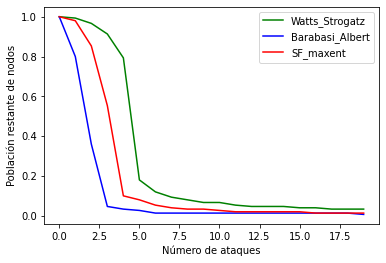

In [ ]:
GA2 = GA.copy()
GB2 = GB.copy()
GW2 = GW.copy()
num_attacks = 20
GW2, ATTACKW,DAMAGEW = hub_cascade_failure(GW2,1,1.1,num_attacks)
GB2, ATTACKB,DAMAGEB = hub_cascade_failure(GB2,1,1.1,num_attacks)
GA2, ATTACK,DAMAGE = hub_cascade_failure(GA2,1,1.1,num_attacks)

print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

plt.plot(ATTACKW,DAMAGEW,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DAMAGEB,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAMAGE,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 1)
#plt.savefig("hub_cascade_failure.jpg", bbox_inches = "tight", dpi= 300)

31.173576042428973 68.397535642997 53.713258395213


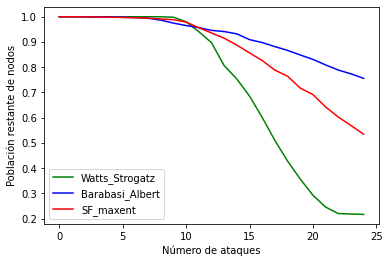

In [ ]:
#ataque aleatorio promedio sobre 60 ataques
muestra = 60
DW = []
DB = []
DA = []
for i in range(muestra):
  GA2 = GA.copy()
  GB2 = GB.copy()
  GW2 = GW.copy()
  num_attacks = 25
  GW2, ATTACKW,DAMAGEW = aleatory_cascade_failure(GW2,1,1.1,num_attacks)
  GB2, ATTACKB,DAMAGEB = aleatory_cascade_failure(GB2,1,1.1,num_attacks)
  GA2, ATTACK,DAMAGE = aleatory_cascade_failure(GA2,1,1.1,num_attacks)
  DW.append(DAMAGEW)
  DB.append(DAMAGEB)
  DA.append(DAMAGE)
DWP = []
DBP = []
DAP = []
for j in range(len(DW[3])):
  sumw = 0
  sumb = 0
  suma = 0
  for i in range(muestra):
    sumw = sumw + DW[i][j]
    sumb = sumb + DB[i][j]
    suma = suma + DA[i][j]
  DWP.append(sumw/muestra)
  DBP.append(sumb/muestra)
  DAP.append(suma/muestra)
plt.plot(ATTACKW,DWP,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DBP,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAP,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 3)
#plt.savefig("aleatory_cascade_failureprom.jpg", bbox_inches = "tight", dpi= 300)

for i in range(len(DAMAGEW)):
  sumw = sumw + DWP[i]
  sumb = sumb + DBP[i]
  suma = suma + DAP[i]
print(sumw,sumb,suma)




148.09111111111122 212.52800000000033 199.94177777777762


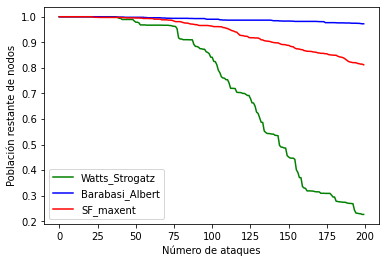

In [ ]:
#ATAQUE ALEATORIO A LOS ENLACES MUESTRA 15
muestra = 15
DW = []
DB = []
DA = []
for i in range(muestra):
  GA2 = GA.copy()
  GB2 = GB.copy()
  GW2 = GW.copy()
  num_attacks = 200
  GW2, ATTACKW,DAMAGEW = edge_aleatory_cascade_failure(GW2,1,1.1,num_attacks)
  GB2, ATTACKB,DAMAGEB = edge_aleatory_cascade_failure(GB2,1,1.1,num_attacks)
  GA2, ATTACK,DAMAGE = edge_aleatory_cascade_failure(GA2,1,1.1,num_attacks)
  DW.append(DAMAGEW)
  DB.append(DAMAGEB)
  DA.append(DAMAGE)
DWP = []
DBP = []
DAP = []
for j in range(len(DW[3])):
  sumw = 0
  sumb = 0
  suma = 0
  for i in range(muestra):
    sumw = sumw + DW[i][j]
    sumb = sumb + DB[i][j]
    suma = suma + DA[i][j]
  DWP.append(sumw/muestra)
  DBP.append(sumb/muestra)
  DAP.append(suma/muestra)

plt.plot(ATTACKW,DWP,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DBP,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAP,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 3)
#plt.savefig("edge_aleatory_cascade_failureprom.jpg", bbox_inches = "tight", dpi= 300)
for i in range(len(DAMAGEW)):
  sumw = sumw + DWP[i]
  sumb = sumb + DBP[i]
  suma = suma + DAP[i]
print(sumw,sumb,suma)


1.114766954911782 1.5085039464619077 1.5528383714354508 degree
2.9190953439916725 2.0811088448557 2.5081291703888775 eigen
2.827622838479781 0.9484104199478295 1.860843950324934 betweenness
3.0119134540429884 2.663457284591288 2.932797649217195 closeness
3.401197381662155 3.401197381662155 3.401197381662155 load
280.2177777777782 361.2546666666678 356.76177777777804


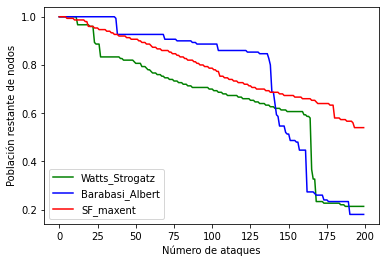

In [ ]:
GA2 = GA.copy()
GB2 = GB.copy()
GW2 = GW.copy()

num_attacks = 200
GW2, ATTACKW,DAMAGEW = edge_hub_cascade_failure(GW2,1,1.1,num_attacks)
GB2, ATTACKB,DAMAGEB = edge_hub_cascade_failure(GB2,1,1.1,num_attacks)
GA2, ATTACK,DAMAGE = edge_hub_cascade_failure(GA2,1,1.1,num_attacks)

print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

plt.plot(ATTACKW,DAMAGEW,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DAMAGEB,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAMAGE,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 3)
#plt.savefig("edge_hub_cascade_failure.jpg", bbox_inches = "tight", dpi= 300)
for i in range(len(DAMAGEW)):
  sumw = sumw + DAMAGEW[i]
  sumb = sumb + DAMAGEB[i]
  suma = suma + DAMAGE[i]
print(sumw,sumb,suma)